# Sentiment Analysis

### Supervised Learning

In [5]:
# Libreria standard
import os
import re
import string
import sys
from collections import Counter
from time import time
from datetime import datetime

# Utility
from unidecode import unidecode
from tqdm import tqdm

# Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

In [3]:
data_path = os.path.join('dati', 'betsentiment-IT-tweets-sentiment-players.csv')
dati = pd.read_csv(data_path, encoding='latin-1')

In [4]:
def clean_text(text: str):
    clean_text = re.sub(r'@[a-z0-9]+\b', ' ', text.lower())
    clean_text = re.sub(r'[^a-zàáèéíìòóùú0-9]', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    clean_text = unidecode(clean_text)
    return clean_text

In [5]:
vocab = {'0': 0}
for tweet in dati['tweet_text']:
    pulito = clean_text(tweet).split()
    for word in pulito:
        if word not in vocab:
            vocab[word] = len(vocab)

In [6]:
clean_texts = [clean_text(tweet) for tweet in dati['tweet_text']]

In [7]:
token_text = [[vocab.get(word, 0) for word in text.split()] for text in clean_texts]

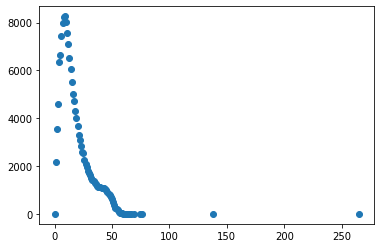

In [8]:
x = [len(frase) for frase in token_text]
counts = Counter(x)
plt.scatter(list(counts.keys()), list(counts.values()))

In [9]:
np.mean(x) + 3*np.std(x)

52.84616033095599

In [10]:
np.mean(x) - 3*np.std(x)

-19.365775564800934

In [19]:
config = {
    'num_emb': len(vocab),
    'emb_dim': 300, # Hyperparameter iperparametro
    'conv_out': 100,
    'kernel_size': 3,
    'n_epochs': 100,
    'batch_size': 512,
    'seq_len': 53, # Dalla deviazione standard
    'n_classes': 4
}

NameError: name 'vocab' is not defined

In [12]:
torch_tokens = torch.zeros((len(token_text), config['seq_len']), dtype=torch.int64)
for fid, frase in enumerate(token_text):
    for pid, parola in enumerate(frase[:53]):
        torch_tokens[fid, pid] = parola

In [13]:
sentiment_to_id = {'MIXED': 0, 'NEGATIVE': 1, 'NEUTRAL': 2, 'POSITIVE': 3}
labels = [sentiment_to_id[s] for s in dati['sentiment']]
torch_labels = torch.tensor(labels, dtype=torch.int64)

In [17]:
class TextClassifier(nn.Module):
    def __init__(self, config):
        super(TextClassifier, self).__init__()
        
        num_emb = config['num_emb']
        emb_dim = config['emb_dim']
        conv_out = config['conv_out']
        kernel_size = config['kernel_size']
        seq_len = config['seq_len']
        n_classes = config['n_classes']
        self.emb = nn.Embedding(num_emb, emb_dim)
        self.conv = nn.Conv1d(emb_dim, conv_out, kernel_size)
        self.fc = nn.Linear(conv_out*self.__output(kernel_size, seq_len), n_classes)
    
    
    def forward(self, x):
        x = self.emb(x)
        x = torch.transpose(x, 1, 2)
        x = self.conv(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]))
        x = self.fc(x)
        return x
    
    def __output(self, kernel_size, seq_len):
        return seq_len - kernel_size + 1

In [3]:
def calculate_metrics(y_pred, y_true, labels=[0, 1, 2, 3]):
    matches = 0
    for p, t in zip(y_pred, y_true):
        matches += 1 if p == t else 0
    accuracy = matches/len(y_true)
    
    confusion_matrix = np.zeros((len(labels), len(labels)))
    for p, t in zip(y_pred, y_true):
        confusion_matrix[p, t] += 1
    print(confusion_matrix)
    precision = np.divide(np.diag(confusion_matrix), np.sum(confusion_matrix, axis=1),
                          out=np.zeros_like(np.diag(confusion_matrix)),
                          where=np.sum(confusion_matrix, axis=1)!=0)
    recall = np.divide(np.diag(confusion_matrix), np.sum(confusion_matrix, axis=0),
                          out=np.zeros_like(np.diag(confusion_matrix)),
                          where=np.sum(confusion_matrix, axis=0)!=0)
    f1 = np.divide(2*precision*recall, (precision+recall), 
                   out=np.zeros_like(precision),
                   where=(precision+recall)!=0)
    return accuracy, precision, recall, f1

In [6]:
y_true = [0, 0, 1, 2, 3, 2, 3, 1, 1, 0]
y_pred = [0, 0, 2, 2, 3, 2, 3, 1, 0, 0]
calculate_metrics(y_pred, y_true)

[[3. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 2. 0.]
 [0. 0. 0. 2.]]


(0.8,
 array([0.75      , 1.        , 0.66666667, 1.        ]),
 array([1.        , 0.33333333, 1.        , 1.        ]),
 array([0.85714286, 0.5       , 0.8       , 1.        ]))

In [50]:
x_train, x_test, y_train, y_test = train_test_split(torch_tokens, torch_labels)

In [53]:
writer = SummaryWriter()

tc = TextClassifier(config)
loss = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(tc.parameters())

writer.add_graph(tc, x_test[0:1])
# Qui comincia l'allenamento
batch_size = config['batch_size']
start = time()
for epoch in tqdm(range(config['n_epochs'])):
    train_loss = []
    tc.train()
    train_pred = np.array([], dtype=np.int64)
    for batch in range(0, len(x_train), batch_size):
        optimiser.zero_grad()
        y_pred = tc(x_train[batch: batch+batch_size])
        l = loss(y_pred, y_train[batch: batch+batch_size])
        l.backward()
        optimiser.step()
        train_loss.append(l.item())
        train_pred = np.concatenate([train_pred, 
                                     np.argmax(y_pred.detach().numpy(), axis=1).astype(np.int64)])
    train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_pred, y_train)
    
    test_loss = []
    tc.eval()
    test_pred = np.array([], dtype=np.int64)
    with torch.no_grad():
        for batch in range(0, len(x_test), batch_size):
            y_pred_test = tc(x_test[batch: batch+batch_size])
            l = loss(y_pred_test, y_test[batch: batch+batch_size])
            test_loss.append(l.item())
            test_pred = np.concatenate([test_pred, 
                                        np.argmax(y_pred_test.detach().numpy(), axis=1).astype(np.int64)])
    test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(test_pred, y_test)
    writer.add_scalars('Loss', {'Train': np.mean(train_loss),
                                'Test': np.mean(test_loss)}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_accuracy,
                                'Test': test_accuracy}, epoch)
    writer.add_scalars('Precision', {'Train_Mixed': train_precision[0],
                                     'Train_Negative': train_precision[1],
                                     'Train_Neutral': train_precision[2],
                                     'Train_Positive': train_precision[3],
                                     'Test_Mixed': test_precision[0],
                                     'Test_Negative': test_precision[1],
                                     'Test_Neutral': test_precision[2],
                                     'Test_Positive': test_precision[3],
                                    }, epoch)
    writer.add_scalars('Recall', { 'Train_Mixed': train_recall[0],
                                   'Train_Negative': train_recall[1],
                                   'Train_Neutral': train_recall[2],
                                   'Train_Positive': train_recall[3],
                                   'Test_Mixed': test_recall[0],
                                   'Test_Negative': test_recall[1],
                                   'Test_Neutral': test_recall[2],
                                   'Test_Positive': test_recall[3] }, epoch)
    writer.add_scalars('F1', { 'Train_Mixed': train_f1[0],
                              'Train_Negative': train_f1[1],
                              'Train_Neutral': train_f1[2],
                              'Train_Positive': train_f1[3],
                              'Test_Mixed': test_f1[0],
                              'Test_Negative': test_f1[1],
                              'Test_Neutral': test_f1[2],
                              'Test_Positive': test_f1[3] }, epoch)

end = time()
totale_secondi = int(end-start)
ore = int((end-start)/3600)
minuti = int(totale_secondi%3600/60)
secondi = int(totale_secondi%60)
print(f'Ci ho messo un totale di {ore} ore, {minuti} minuti e {secondi} secondi\n'
      f'per una media di {totale_secondi/config["n_epochs"]}/epoca')
writer.close()

100%|██████████| 100/100 [1:57:11<00:00, 70.31s/it]

Ci ho messo un totale di 1 ore, 57 minuti e 11 secondi
per una media di 70.31/epoca


In [54]:
torch.save(tc.state_dict(), f'model-{datetime.now().strftime("%Y-%m-%d-%H-%M")}.pth')

In [11]:
arr = np.array([[1,4, 3],[1, 57,3]])

In [12]:
arr.shape

(2, 3)

In [15]:
arr[0:1].shape

(1, 3)

In [18]:
tc_1 = TextClassifier(config)
tc_1.load_state_dict(torch.load('model-2021-03-14-12-01.pth'))

NameError: name 'config' is not defined